In [255]:
# Standard Packages
import pandas as pd
import numpy as np

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt

# Scipy Stats
import scipy.stats as stats 
from scipy.stats import pearsonr

# Statsmodel Api
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor


# SKLearn Modules
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

#Add Extra Modules
from math import sin, cos, sqrt, atan2
from datetime import datetime, timedelta
import cpi
import re



# Suppress future and deprecation warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pd.options.display.max_columns = None
pd.options.display.width = None

In [256]:
data = pd.read_csv("data/kc_house_data.csv")
df_school = pd.read_csv('data/AIM-EOC-MSP-SBA_Assessments_School__with_suppression_-_new_format__2017.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [257]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculates the Haversine distance between two points on the Earth's surface.
    """
    R = 6371  # radius of Earth in km

    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d

# Amazon headquarters GPS location (Seattle city center)
city_lat = 47.6184
city_long = -122.3560

data["distance"] = haversine(city_lat, city_long, data["lat"], data["long"])

In [258]:
# Define a dictionary with the district information
district_dict = {
    17001: ['Seattle', 47.604224, -122.310822],
    17210: ['Federal Way', 47.306740, -122.334571],
    17216: ['Enumclaw', 47.202359, -121.989672],
    17400: ['Mercer Island', 47.563806, -122.221739],
    17401: ['Highline', 47.503040, -122.333787],
    17402: ['Vashon Island', 47.415653, -122.465464],
    17403: ['Renton', 47.480680, -122.194300],
    17404: ['Skykomish', 47.709979, -121.358584],
    17405: ['Bellevue', 47.601939, -122.153399],
    17406: ['Tukwila', 47.465515, -122.264383],
    17408: ['Auburn', 47.298994, -122.209005],
    17409: ['Tahoma', 47.408238, -121.978171],
    17410: ['Snoqualmie Valley', 47.467175, -121.721867],
    17411: ['Issaquah', 47.541392, -122.042553],
    17412: ['Shoreline', 47.758887, -122.340132],
    17414: ['Lake Washington', 47.682244, -122.116046],
    17415: ['Kent', 47.370687, -122.179470],
    17417: ['Northshore', 47.768389, -122.152624],
    27417: ['Fife', 47.246443, -122.331492],
    17407: ['Riverview', 47.706997, -121.847689]
}

# Create a dataframe from the dictionary
df_school_district = pd.DataFrame.from_dict(district_dict, orient='index', columns=['district', 'lat', 'long'])
df_school_district.reset_index(inplace=True)
df_school_district.rename(columns={'index': 'DistrictCode'}, inplace=True)

In [259]:
df_school.dropna(subset=['countLevel4'], inplace=True)
grouped = df_school.groupby("DistrictCode")["PercentMetStandardIncludingPP"].mean()
grouped = grouped.reset_index()
df_school_district = df_school_district.merge(grouped, on="DistrictCode")
df_school_district = df_school_district.rename(columns={"PercentMetStandardIncludingPP": "average_grade"})

# Print the dataframe
df_school_district

,DistrictCode,district,lat,long,average_grade
0,17001,Seattle,47.604224,-122.310822,58.657228
1,17210,Federal Way,47.306740,-122.334571,41.280501
2,17216,Enumclaw,47.202359,-121.989672,58.115776
3,17400,Mercer Island,47.563806,-122.221739,80.494636
4,17401,Highline,47.503040,-122.333787,41.926799
5,17402,Vashon Island,47.415653,-122.465464,43.446809
6,17403,Renton,47.480680,-122.194300,49.046699
7,17405,Bellevue,47.601939,-122.153399,67.680014
8,17406,Tukwila,47.465515,-122.264383,38.709272
9,17408,Auburn,47.298994,-122.209005,53.260763


In [260]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,distance
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,21.373766
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,10.355030
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,16.239531
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,7.625932
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,23.356845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,11/30/2021,1555000.0,5,2.0,1910,4000,1.5,NO,NO,NO,NONE,Good,8 Good,Oil,PUBLIC,1600,1130,0,210,1921,0,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940,5.524721
30151,194000695,6/16/2021,1313000.0,3,2.0,2020,5800,2.0,NO,NO,NO,FAIR,Average,7 Average,Gas,PUBLIC,2020,0,0,520,2011,0,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851,6.356116
30152,7960100080,5/27/2022,800000.0,3,2.0,1620,3600,1.0,NO,NO,YES,NONE,Average,7 Average,Gas,PUBLIC,940,920,240,110,1995,0,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585,4.595769
30153,2781280080,2/24/2022,775000.0,3,2.5,2570,2889,2.0,NO,NO,NO,NONE,Average,8 Good,Gas,PUBLIC,1830,740,480,100,2006,0,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908,22.578612


In [261]:
def closest_school_district(row):
    lat1, lon1 = row['lat'], row['long']
    distances = df_school_district.apply(lambda x: haversine(lat1, lon1, x['lat'], x['long']), axis=1)
    return df_school_district.loc[distances.idxmin(), 'average_grade']

data['school_grade'] = data.apply(closest_school_district, axis=1)

In [262]:
data = data.dropna()
data['waterfront'] = data['waterfront'].apply(lambda x: 1 if x == 'YES' else 0)
data['greenbelt'] = data['greenbelt'].apply(lambda x: 1 if x == 'YES' else 0)
data['nuisance'] = data['nuisance'].apply(lambda x: 1 if x == 'YES' else 0)

C:\Users\Jonat\AppData\Local\Temp\ipykernel_5688\1517801404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['waterfront'] = data['waterfront'].apply(lambda x: 1 if x == 'YES' else 0)
C:\Users\Jonat\AppData\Local\Temp\ipykernel_5688\1517801404.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['greenbelt'] = data['greenbelt'].apply(lambda x: 1 if x == 'YES' else 0)
C:\Users\Jonat\AppData\Local\Temp\ipykernel_5688\1517801404.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [263]:
data['grade'] = data['grade'].str.extract(r'(\d+)').astype(int)
data['grade'].unique()

C:\Users\Jonat\AppData\Local\Temp\ipykernel_5688\3269997502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['grade'] = data['grade'].str.extract(r'(\d+)').astype(int)


array([ 7,  9,  8,  6, 10,  5, 11, 12,  4, 13,  3,  2])

In [264]:
condition_mapping = {'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1}
data['condition'] = data['condition'].map(condition_mapping)
data['condition'].unique()

C:\Users\Jonat\AppData\Local\Temp\ipykernel_5688\4143086753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['condition'] = data['condition'].map(condition_mapping)


array([4, 3, 5, 2, 1], dtype=int64)

In [265]:
view_mapping = {'NONE': 1, 'FAIR': 2, 'AVERAGE': 3, 'GOOD': 4, 'EXCELLENT': 5}
data['view'] = data['view'].map(view_mapping)
data['view'].unique()

C:\Users\Jonat\AppData\Local\Temp\ipykernel_5688\2480032229.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['view'] = data['view'].map(view_mapping)


array([1, 3, 5, 2, 4], dtype=int64)

In [266]:
#heat_source_dummies = pd.get_dummies(data['heat_source'], prefix='heat_source',drop_first=True)
#data = pd.concat([data, heat_source_dummies], axis=1)
data = data.drop(['heat_source'], axis=1)

In [267]:
data['date'] = pd.to_datetime(data['date'])
data = data[data['date'] < '2022-01-01']
data['price'] = data.apply(lambda row: cpi.inflate(row['price'],row['date'].year), axis=1)

In [268]:
def extract_zipcode(address):
    zipcode = re.findall(r'\b\d{5}\b', address)
    if len(zipcode) > 0:
        return zipcode[0]
    else:
        return ''

data['zip_code'] = data['address'].apply(extract_zipcode)

In [269]:
# First, calculate the mean price for each zip code
zip_code_prices = data.groupby('zip_code')['price'].mean()

# Next, divide the zip codes into price categories based on their mean prices
zip_code_categories = pd.cut(zip_code_prices, bins=5, labels=False, retbins=False)

# Finally, add the price category as a new column to the train_data dataframe
data['zip_code_category'] = data['zip_code'].map(zip_code_categories)

data.drop(['zip_code'], axis=1, inplace=True)
data['has_basement'] = (data['sqft_basement'] > 0).astype(int)
data['has_patio'] = (data['sqft_patio'] > 0).astype(int)
data['sqft_garage'] = (data['sqft_garage'] > 0).astype(int)


In [270]:
# Log transform the columns 'price', 'sqft_living', and 'sqft_lot'
data[['sqft_living', 'sqft_lot']] = np.log(data[['sqft_living', 'sqft_lot']])

# Normalize the columns 'price_log', 'sqft_living_log', and 'sqft_lot_log'
data[['sqft_living', 'sqft_lot']] = (data[['sqft_living', 'sqft_lot']] - data[['sqft_living', 'sqft_lot']].mean()) / data[['sqft_living', 'sqft_lot']].std()


In [271]:
train_data, test_data, train_labels, test_labels = train_test_split(data.drop(columns=["id", "address", "lat", "long","sewer_system",'sqft_above','sqft_basement','sqft_patio','sqft_garage']), data["price"], test_size=0.33, random_state=42)

In [272]:
train_data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,yr_built,yr_renovated,distance,school_grade,zip_code_category,has_basement,has_patio
17530,2021-06-11,1070000.0,4,2.5,0.780897,-0.134587,2.0,0,0,1,1,3,8,2000,0,13.071107,73.121797,1,0,1
24392,2021-07-28,660000.0,4,2.5,0.004192,0.092626,2.0,0,0,0,1,3,9,1996,0,36.965699,41.280501,0,0,1
14425,2021-07-08,500000.0,3,2.0,-0.913731,-0.218435,1.0,0,0,0,1,3,7,1956,0,13.995146,41.926799,0,0,1
27656,2021-08-26,600000.0,3,2.0,-1.398335,0.271857,1.0,0,0,0,1,3,7,1985,0,30.964605,62.966387,0,0,1
17096,2021-09-14,1550000.0,3,2.5,0.654247,0.352450,2.0,0,0,0,1,4,10,1989,0,22.032346,67.680014,1,0,0


In [273]:

train_data['yr_renovated'] = np.where(train_data['yr_renovated'] == 0, train_data['yr_built'], train_data['yr_renovated'])
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['year'] = train_data['date'].dt.year
train_data['years_since_build_or_renov'] = train_data['year'] - train_data[['yr_built', 'yr_renovated']].min(axis=1)
train_data.drop(['date', 'year', 'yr_built', 'yr_renovated'], axis=1, inplace=True)

test_data['yr_renovated'] = np.where(test_data['yr_renovated'] == 0, test_data['yr_built'], test_data['yr_renovated'])
test_data['date'] = pd.to_datetime(test_data['date'])
test_data['year'] = test_data['date'].dt.year
test_data['years_since_build_or_renov'] = test_data['year'] - test_data[['yr_built', 'yr_renovated']].min(axis=1)
test_data.drop(['date', 'year', 'yr_built', 'yr_renovated'], axis=1, inplace=True)


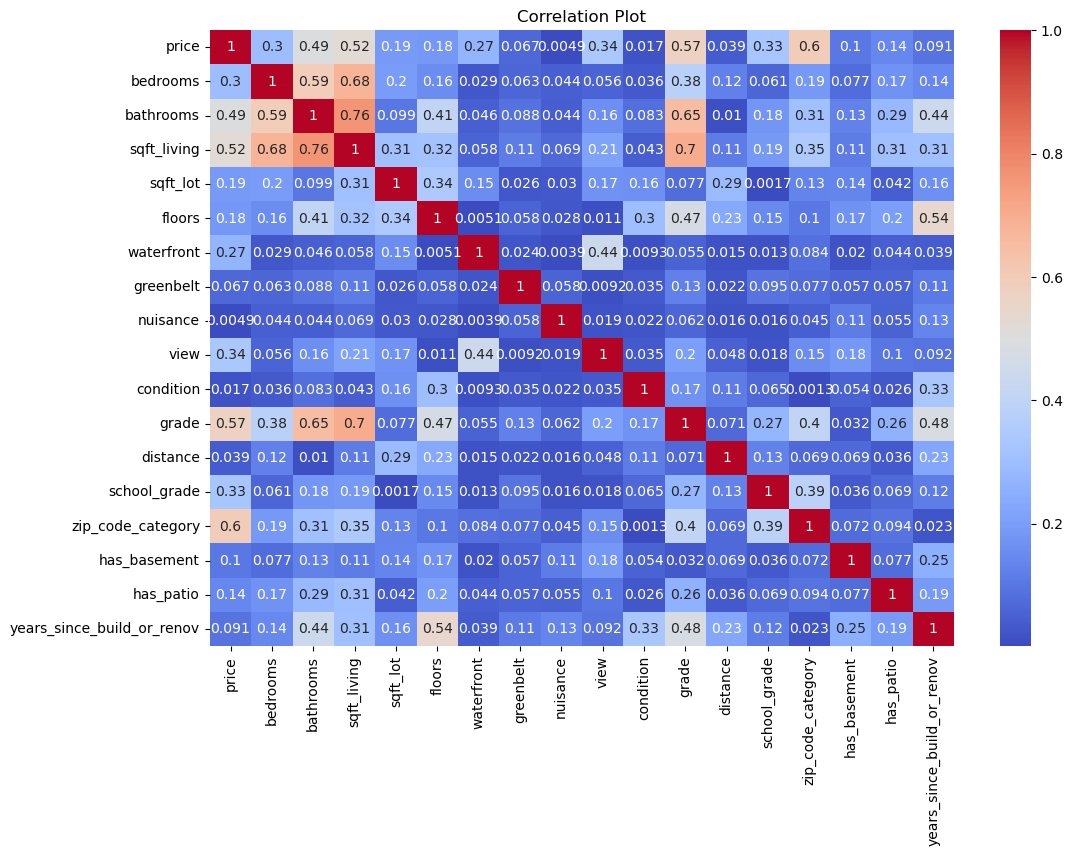

In [274]:
# Calculate the correlation matrix
corr = abs(train_data.corr())

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Add a title to the plot
plt.title("Correlation Plot")

# Show the plot
plt.show()

In [275]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12904 entries, 17530 to 24757
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price                       12904 non-null  float64
 1   bedrooms                    12904 non-null  int64  
 2   bathrooms                   12904 non-null  float64
 3   sqft_living                 12904 non-null  float64
 4   sqft_lot                    12904 non-null  float64
 5   floors                      12904 non-null  float64
 6   waterfront                  12904 non-null  int64  
 7   greenbelt                   12904 non-null  int64  
 8   nuisance                    12904 non-null  int64  
 9   view                        12904 non-null  int64  
 10  condition                   12904 non-null  int64  
 11  grade                       12904 non-null  int32  
 12  distance                    12904 non-null  float64
 13  school_grade               

In [276]:
X = train_data.drop(['price'], axis=1)
y = train_data['price']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     1079.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:08:55   Log-Likelihood:            -1.8924e+05
No. Observations:               12904   AIC:                         3.785e+05
Df Residuals:                   12886   BIC:                         3.787e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [277]:
train_data.drop(['bathrooms', 'bedrooms'], axis=1, inplace=True)

test_data.drop(['bathrooms', 'bedrooms'], axis=1, inplace=True)

In [278]:
X = train_data.drop(['price'], axis=1)
y = train_data['price']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     1157.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:08:55   Log-Likelihood:            -1.8945e+05
No. Observations:               12904   AIC:                         3.789e+05
Df Residuals:                   12888   BIC:                         3.790e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [279]:
train_data = train_data[train_data['distance'] <= 50]
train_data = train_data[train_data['price'] <= 3000000]

test_data = test_data[test_data['distance'] <= 50]
test_data = test_data[test_data['price'] <= 3000000]

In [280]:
vif = [variance_inflation_factor(train_data.values, i) for i in range(train_data.shape[1])]
vif_df = pd.DataFrame({'Features': train_data.columns, 'VIF': vif})
vif_df.sort_values('VIF', ascending=False)

,Features,VIF
9,grade,66.745454
11,school_grade,30.986865
8,condition,25.713420
3,floors,16.258590
0,price,15.579490
10,distance,8.751845
15,years_since_build_or_renov,5.930026
14,has_patio,4.953616
7,view,4.546776
13,has_basement,2.849509


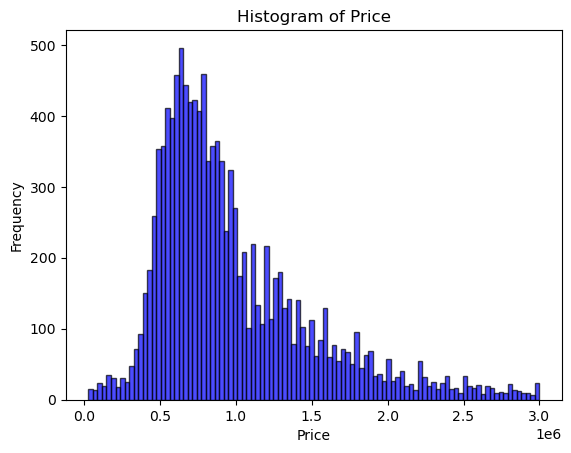

In [281]:
plt.hist(train_data['price'], bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price')
plt.show()


In [282]:
X = train_data.drop(['price'], axis=1)
y = train_data['price']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     1973.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:08:56   Log-Likelihood:            -1.6759e+05
No. Observations:               12006   AIC:                         3.352e+05
Df Residuals:                   11990   BIC:                         3.353e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [283]:
price = train_data['price']
distance = train_data['years_since_build_or_renov']
corr, _ = pearsonr(price, distance)
print('Pearson Correlation Coefficient: %.3f' % corr)

Pearson Correlation Coefficient: -0.110


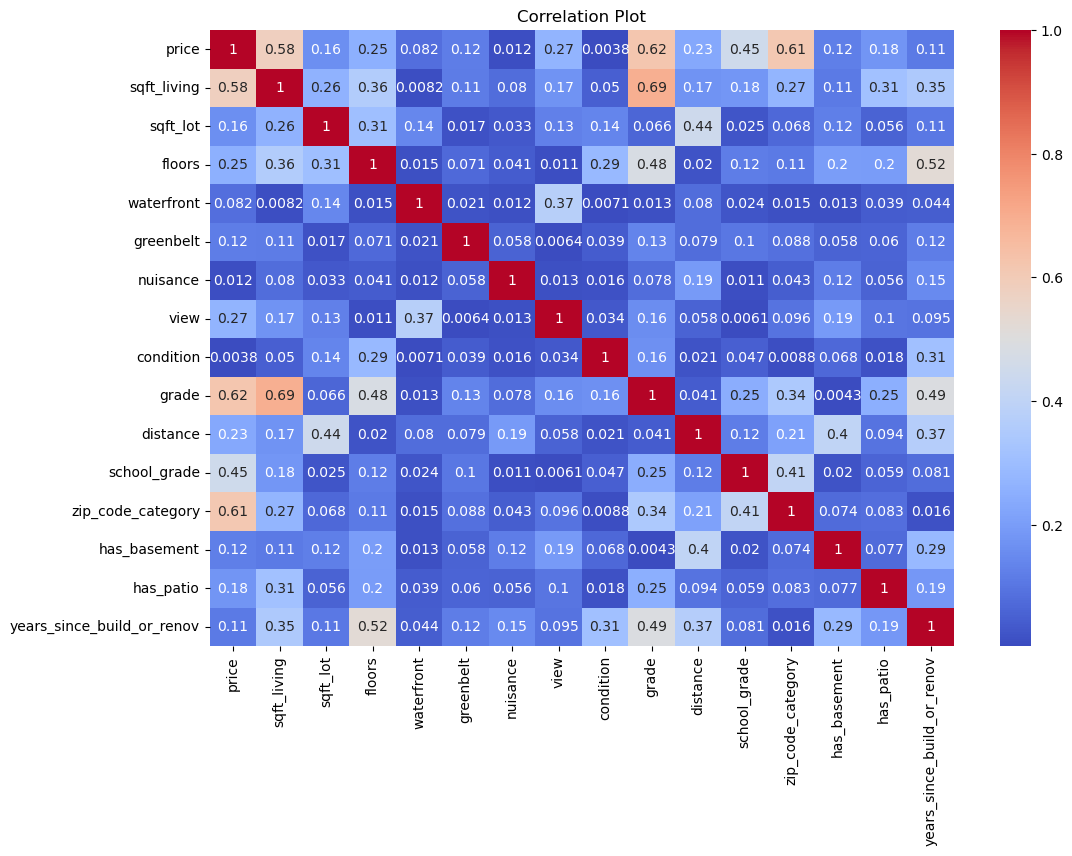

In [284]:
# Calculate the correlation matrix
corr = abs(train_data.corr())

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Add a title to the plot
plt.title("Correlation Plot")

# Show the plot
plt.show()

In [285]:
X = train_data.drop(['price'], axis=1)
y = train_data['price']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     1973.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:08:58   Log-Likelihood:            -1.6759e+05
No. Observations:               12006   AIC:                         3.352e+05
Df Residuals:                   11990   BIC:                         3.353e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

<AxesSubplot: xlabel='sqft_living', ylabel='price'>

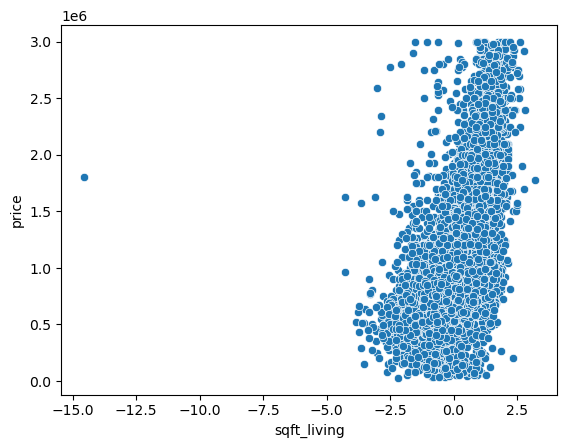

In [286]:
sns.scatterplot(x='sqft_living', y='price', data=train_data)


In [287]:
train_data = train_data[train_data['sqft_living'] > -10]
test_data = test_data[test_data['sqft_living'] > -10]

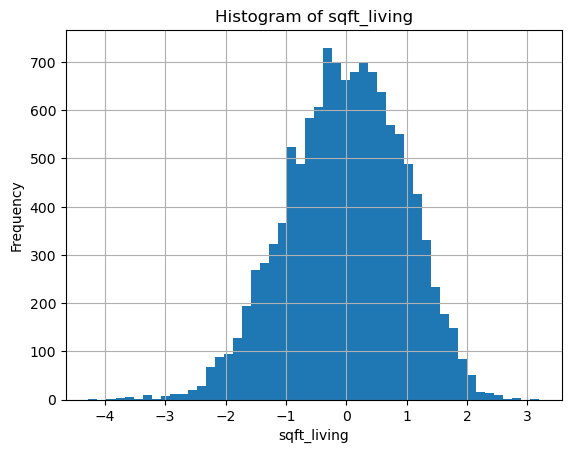

In [288]:
train_data['sqft_living'].hist(bins=50)
plt.xlabel('sqft_living')
plt.ylabel('Frequency')
plt.title('Histogram of sqft_living')
plt.show()

In [289]:
train_data.drop(["has_patio"], axis=1, inplace=True)
test_data.drop(["has_patio"], axis=1, inplace=True)

train_data.drop(["grade"], axis=1, inplace=True)
test_data.drop(["grade"], axis=1, inplace=True)

In [290]:
test_data.describe()

,price,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,distance,school_grade,zip_code_category,has_basement,years_since_build_or_renov
count,5.884000e+03,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000
mean,9.760008e+05,-0.013100,0.024739,1.508073,0.011897,0.022264,0.175901,1.259857,3.499150,19.914998,59.551300,0.334126,0.490143,46.871346
std,5.185890e+05,0.932394,0.925945,0.544527,0.108430,0.147553,0.380768,0.800696,0.710165,11.417721,11.836492,0.538680,0.499945,31.194110
min,2.830700e+04,-4.049789,-2.681708,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.744201,38.709272,0.000000,0.000000,-1.000000
25%,6.200000e+05,-0.650710,-0.395514,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000,10.039416,49.046699,0.000000,0.000000,20.000000
50%,8.260000e+05,0.015758,-0.002874,1.500000,0.000000,0.000000,0.000000,1.000000,3.000000,17.784019,58.657228,0.000000,0.000000,45.000000
75%,1.200000e+06,0.654247,0.320546,2.000000,0.000000,0.000000,0.000000,1.000000,4.000000,28.211693,70.535746,1.000000,1.000000,67.250000
max,3.000000e+06,3.108201,5.699610,4.000000,1.000000,1.000000,1.000000,5.000000,5.000000,49.960621,80.494636,4.000000,1.000000,121.000000


In [291]:
train_data[['price', 'distance', 'years_since_build_or_renov']] = (train_data[['price', 'distance', 'years_since_build_or_renov']] - train_data[['price', 'distance', 'years_since_build_or_renov']].mean()) / train_data[['price', 'distance', 'years_since_build_or_renov']].std()

test_data[['price', 'distance', 'years_since_build_or_renov']] = (test_data[['price', 'distance', 'years_since_build_or_renov']] - test_data[['price', 'distance', 'years_since_build_or_renov']].mean()) / test_data[['price', 'distance', 'years_since_build_or_renov']].std()

In [292]:
X = train_data.drop(['price'], axis=1)
y = train_data['price']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     2044.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:08:59   Log-Likelihood:                -10022.
No. Observations:               12005   AIC:                         2.007e+04
Df Residuals:                   11991   BIC:                         2.018e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

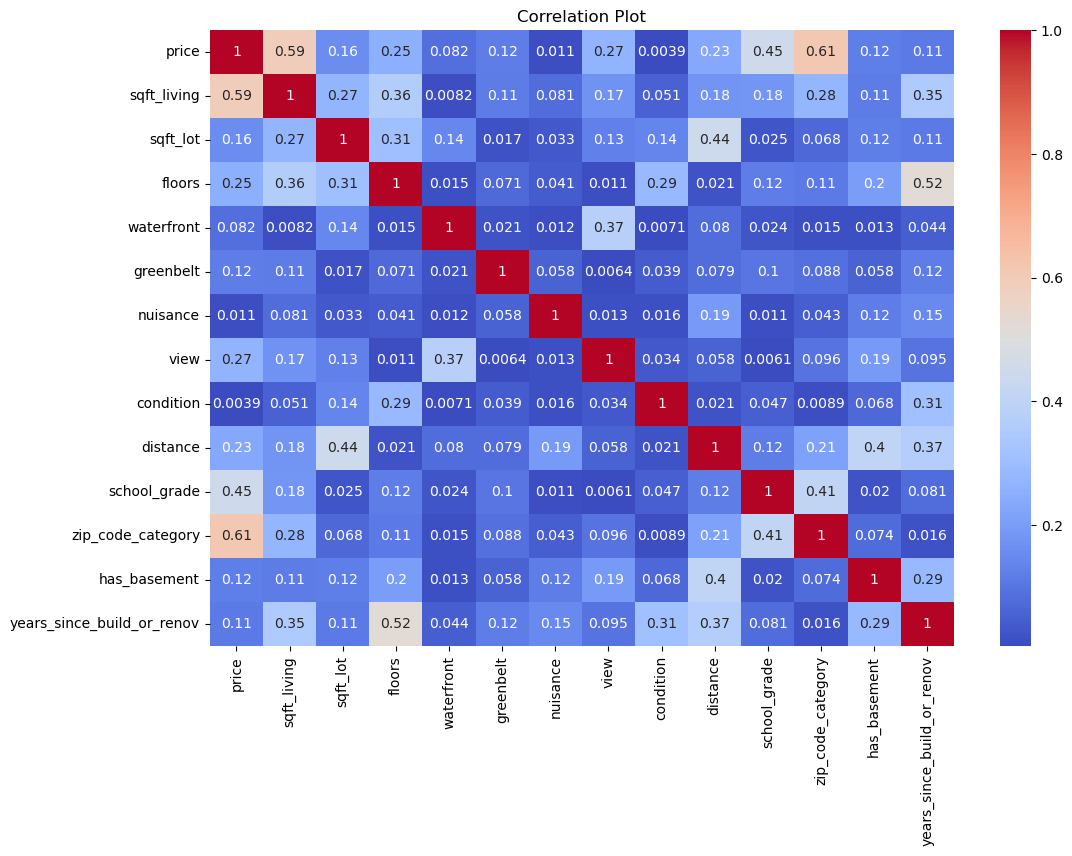

In [293]:
# Calculate the correlation matrix
corr = abs(train_data.corr())

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Add a title to the plot
plt.title("Correlation Plot")

# Show the plot
plt.show()

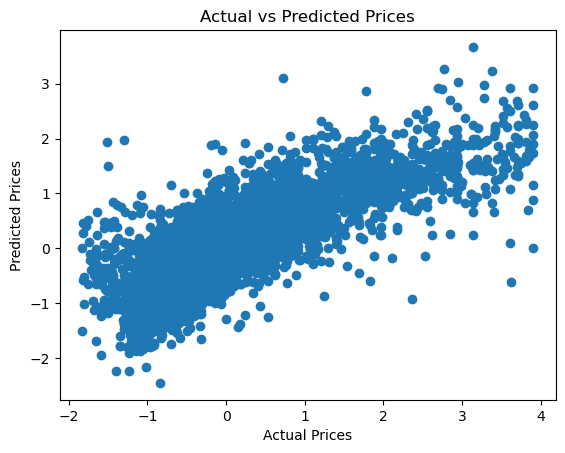

In [294]:
# Fit the model to the training data
model = sm.OLS(train_data['price'], train_data.drop(['price'], axis=1))
results = model.fit()

# Use the fitted model to make predictions on the test data
y_hat_train = results.predict(train_data.drop(['price'], axis=1))
predictions = results.predict(test_data.drop(['price'], axis=1))

# Compare the predicted values with the actual prices in the test data
plt.scatter(test_data['price'], predictions)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

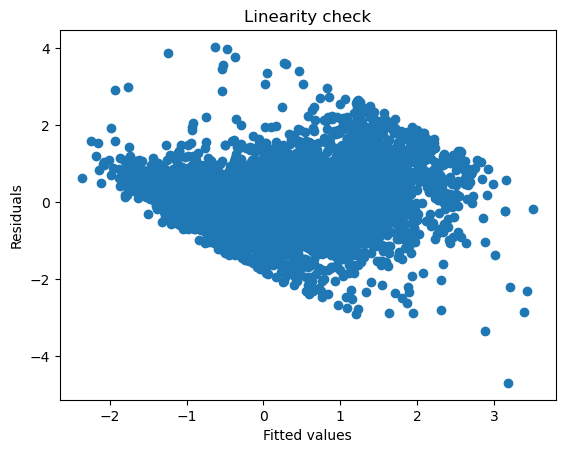

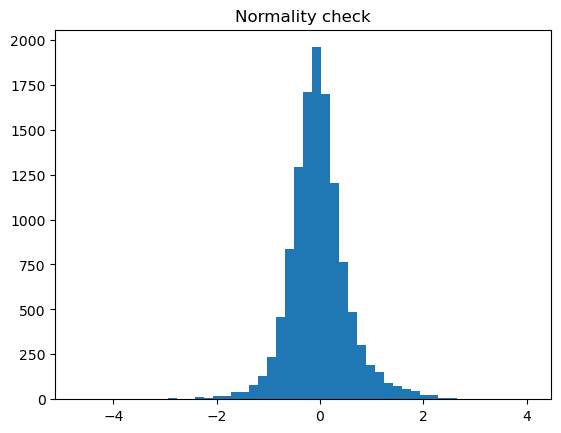

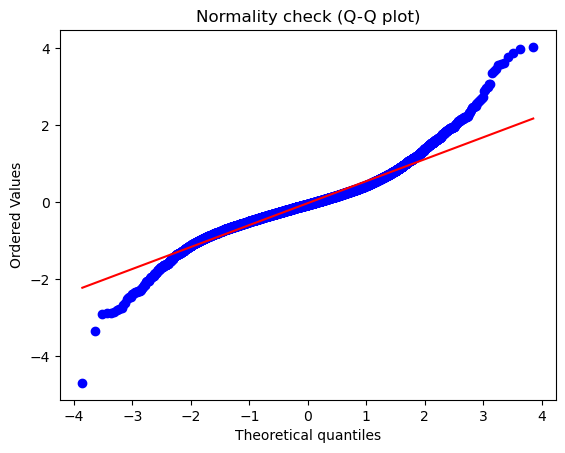

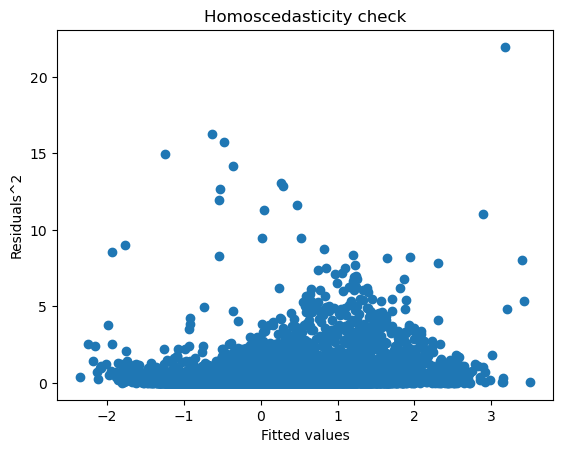

In [295]:
# calculate the residuals
residuals = results.resid

# Plot the residuals against the fitted values to check for linearity
plt.scatter(results.fittedvalues, residuals)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Linearity check")
plt.show()

# Plot a histogram of the residuals to check for normality
plt.hist(residuals, bins=50)
plt.title("Normality check")
plt.show()

# Plot a Q-Q plot of the residuals to check for normality
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normality check (Q-Q plot)")
plt.show()

# Plot the residuals against the fitted values to check for homoscedasticity
plt.scatter(results.fittedvalues, residuals**2)
plt.xlabel("Fitted values")
plt.ylabel("Residuals^2")
plt.title("Homoscedasticity check")
plt.show()